In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydotplus
import matplotlib.image as mpimg
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import datasets, tree
from sklearn import externals
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import export_graphviz
from sklearn import externals
from io import StringIO
from IPython.display import Image
from sklearn import tree 

import warnings
warnings.filterwarnings('ignore')

### 1 - Business Problem

#### Use Random Forest to prepare a model on fraud data treating those who have taxable_income <= 30000 as "Risky" and others are "Good"

### 2 - Data collection and description

In [2]:
fraud_check = pd.read_csv('Fraud_check.csv')
fraud_check1 = fraud_check.copy()
fraud_check1

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO
...,...,...,...,...,...,...
595,YES,Divorced,76340,39492,7,YES
596,YES,Divorced,69967,55369,2,YES
597,NO,Divorced,47334,154058,0,YES
598,YES,Married,98592,180083,17,NO


In [3]:
fraud_check1.describe().T

,count,mean,std,min,25%,50%,75%,max
Taxable.Income,600.0,55208.375000,26204.827597,10003.0,32871.50,55074.5,78611.75,99619.0
City.Population,600.0,108747.368333,49850.075134,25779.0,66966.75,106493.5,150114.25,199778.0
Work.Experience,600.0,15.558333,8.842147,0.0,8.00,15.0,24.00,30.0


In [4]:
fraud_check1.isna().sum()

Undergrad          0
Marital.Status     0
Taxable.Income     0
City.Population    0
Work.Experience    0
Urban              0
dtype: int64

In [5]:
fraud_check1.dtypes

Undergrad          object
Marital.Status     object
Taxable.Income      int64
City.Population     int64
Work.Experience     int64
Urban              object
dtype: object

### Outlier Check

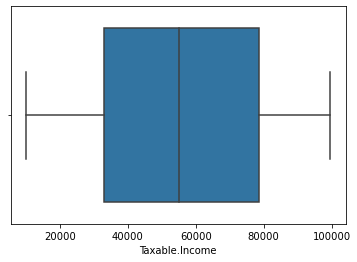

In [6]:
ax = sns.boxplot(fraud_check1['Taxable.Income'])

### There are no outliers in the data

Skew:0.030014788906377175
Kurtosis:-1.1997824607083138


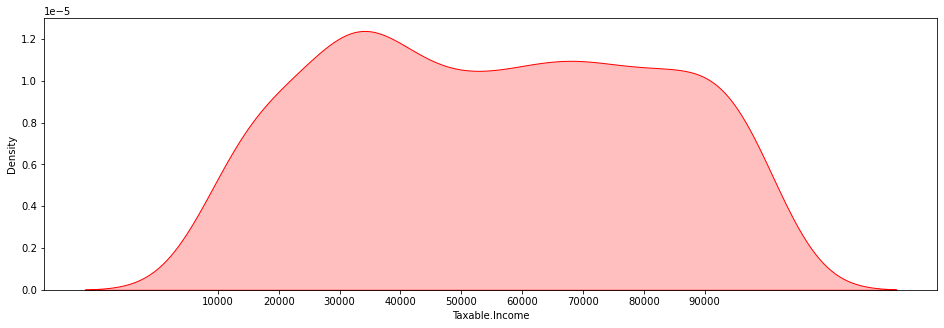

In [7]:
plt.rcParams['figure.figsize'] = 9,5
plt.figure(figsize=(16,5))
print("Skew:{}".format(fraud_check1['Taxable.Income'].skew()))
print("Kurtosis:{}".format(fraud_check1['Taxable.Income'].kurtosis()))
ax = sns.kdeplot(fraud_check1['Taxable.Income'],shade=True,color='r')
plt.xticks([i for i in range(10000,100000,10000)])
plt.show()

### The data is Skwed on the right

### The data has negative Kurtosis

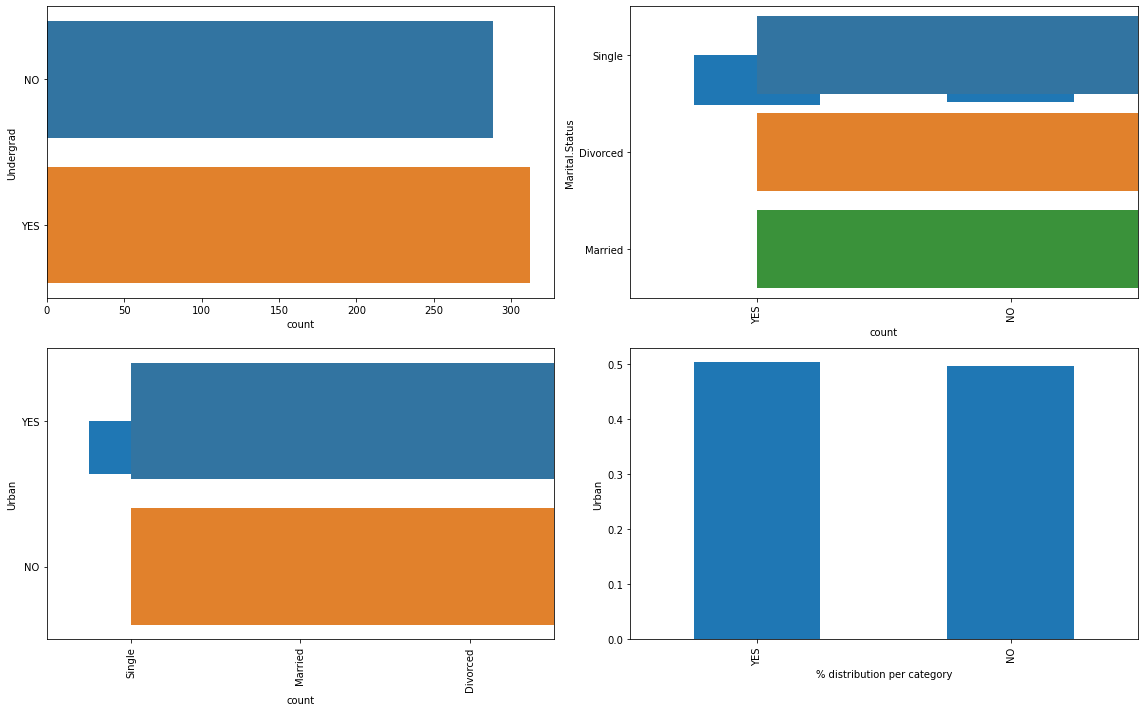

In [8]:
obj_colum = fraud_check1.select_dtypes(include='object').columns.tolist()

plt.figure(figsize = (16,10))
for i,col in enumerate(obj_colum,1):
    plt.subplot(2,2,i)
    sns.countplot(data=fraud_check1,y=col)
    plt.subplot(2,2,i+1)
    fraud_check1[col].value_counts(normalize=True).plot.bar()
    plt.ylabel(col)
    plt.xlabel('% distribution per category')
plt.tight_layout()
plt.show()

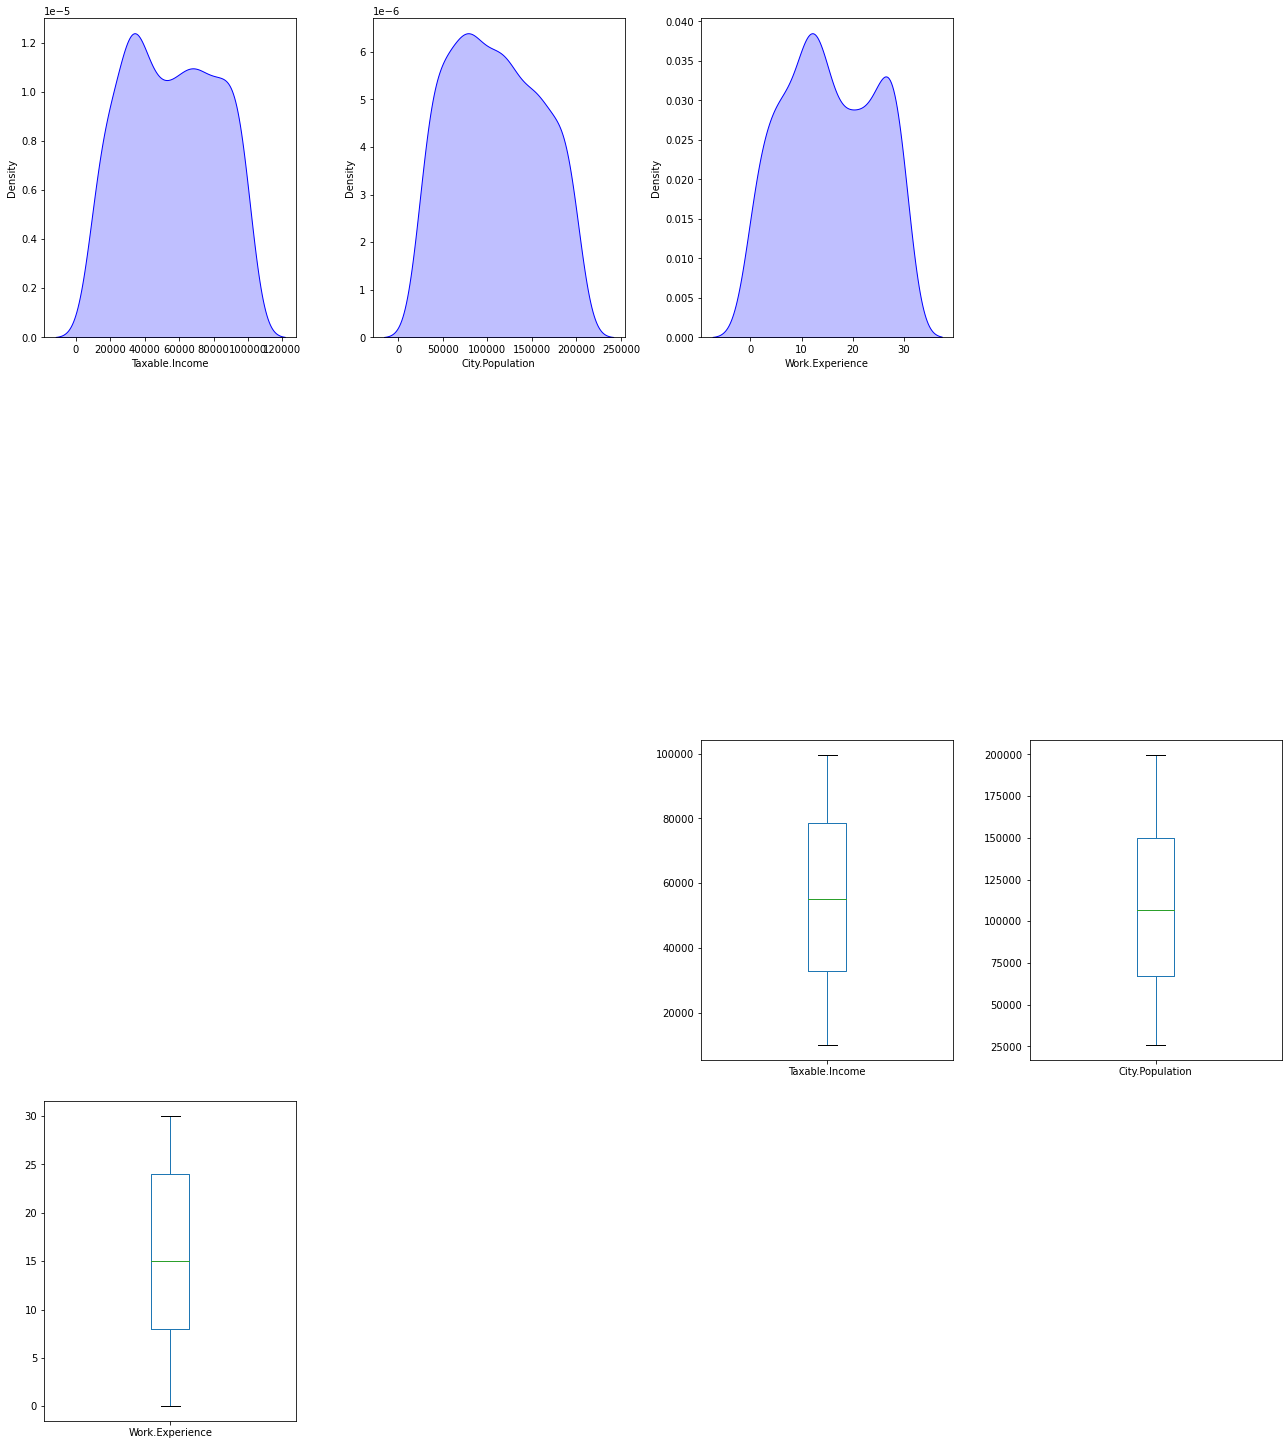

,Taxable.Income,City.Population,Work.Experience
skewness,0.030015,0.125009,0.018529
kurtosis,-1.199782,-1.120154,-1.167524


In [9]:
num_columns = fraud_check1.select_dtypes(exclude='object').columns.tolist()

plt.figure(figsize=(18,40))
for i,col in enumerate(num_columns,1):
    plt.subplot(8,4,i)
    sns.kdeplot(fraud_check[col],color='b',shade=True)
    plt.subplot(8,4,i+10)
    fraud_check[col].plot.box()
plt.tight_layout()
plt.show()
num_data=fraud_check[num_columns]
pd.DataFrame(data=[num_data.skew(),num_data.kurtosis()],index=['skewness','kurtosis'])

In [10]:
fraud_check1=pd.get_dummies(fraud_check1,columns=['Undergrad','Marital.Status','Urban'])

In [11]:
corr=fraud_check1.corr()

<AxesSubplot:>

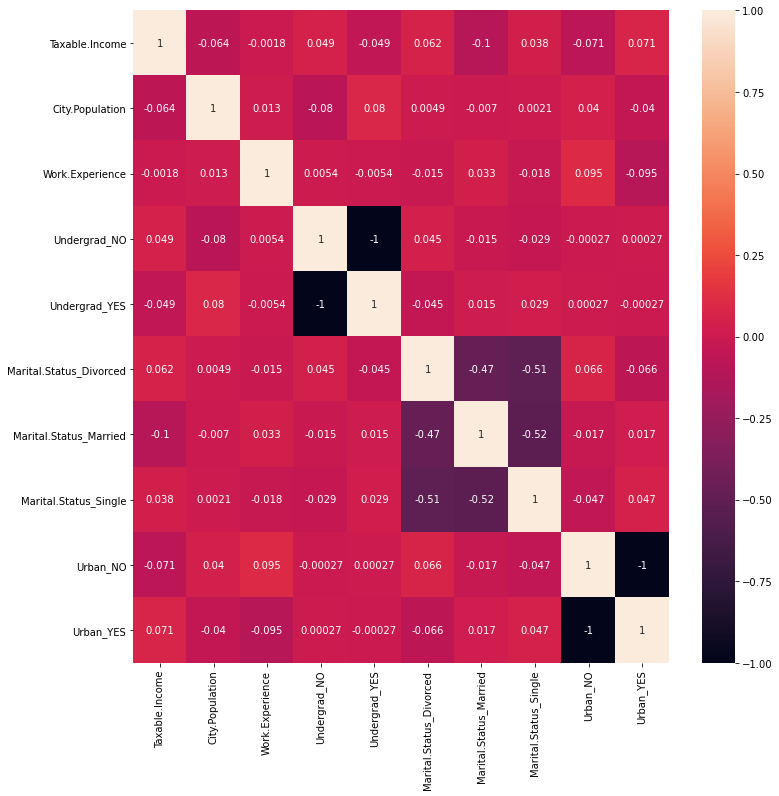

In [12]:
corr=fraud_check1.corr()
plt.figure(figsize=(12,12))
sns.heatmap(corr,annot=True)

### 3 - Random Forest Model

#### Since the target variable is continious, we create a class of taxable_income <= 30000 as "Risky" and others are "Good"¶

In [13]:
fraud_check1['Taxable.Income'] = pd.cut(fraud_check1['Taxable.Income'],bins=[0,30000,100000],labels=['risky','good'])

In [14]:
list(fraud_check1.columns)

['Taxable.Income',
 'City.Population',
 'Work.Experience',
 'Undergrad_NO',
 'Undergrad_YES',
 'Marital.Status_Divorced',
 'Marital.Status_Married',
 'Marital.Status_Single',
 'Urban_NO',
 'Urban_YES']

In [20]:
X = fraud_check1.iloc[:,1:10]
y = fraud_check1.iloc[:,0]

In [21]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,stratify = y)

In [22]:
y_train.value_counts()

good     381
risky     99
Name: Taxable.Income, dtype: int64

In [26]:
model=RF(n_jobs=4,n_estimators=150, oob_score=True,criterion='entropy')
model.fit(X_train,y_train)
model.oob_score_

0.7375

In [33]:
pred_train=model.predict(X_train)
print('Accuracy Score:', accuracy_score(y_train,pred_train))
print('Confusion Matrix:\n',confusion_matrix(y_train,pred_train))

Accuracy Score: 1.0
Confusion Matrix:
 [[381   0]
 [  0  99]]


In [34]:
pred_test = model.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test,pred_test))
print('Confusion Matrix:\n',confusion_matrix(y_test,pred_test))

Accuracy Score: 0.725
Confusion Matrix:
 [[85 10]
 [23  2]]


In [35]:
fc_t=pd.DataFrame({'Actual':y_test, 'Predicted':pred_test})
fc_t

,Actual,Predicted
503,good,risky
131,good,good
410,good,good
233,risky,good
280,risky,good
...,...,...
475,good,good
383,good,risky
331,risky,good
62,good,risky


In [36]:
cols = list(fraud_check1.columns)
predictors = cols[1:10]
target = cols[0]

In [43]:
tree1 = model.estimators_[20]

In [44]:
dot_data = StringIO()

In [45]:
export_graphviz(tree1, out_file = dot_data, feature_names =predictors, class_names = target, filled =True,rounded=True,impurity =False,proportion=False,precision =2)

In [46]:
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

In [52]:
graph = graph.write_png('fraud_full.png')

InvocationException: GraphViz's executables not found

### 4 - Conclusion

### Since the accuracy of the Training set is 100% we test the accurancy on the test data which is 72%

### As seen in the confusion matrix of Test data 87 instances are presdected correctly and 33 instances are not

In [77]:
rf_small = RF(n_estimators=10, max_depth = 3)

In [78]:
rf_small.fit(X_train,y_train)

RandomForestClassifier(max_depth=3, n_estimators=10)

In [79]:
tree_small = rf_small.estimators_[5]

In [80]:
export_graphviz(tree_small, out_file = dot_data, feature_names = predictors, rounded = True, precision = 1)

In [81]:
graph_small = pydotplus.graph_from_dot_data(dot_data.getvalue())

In [82]:
graph.write_png('fraud_small.png')

InvocationException: GraphViz's executables not found

In [83]:
img = mpimg.imread('fraud_small.png')

SyntaxError: not a PNG file (<string>)

In [84]:
plt.imshow(img)

NameError: name 'img' is not defined

In [70]:
model.feature_importances_

array([0.50457149, 0.36204475, 0.01623505, 0.01656098, 0.02108891,
       0.02055401, 0.01918947, 0.01844312, 0.02131222])

In [76]:
fc = pd.DataFrame({'Feature':list(X_train.columns),
                 'Importance':model.feature_importances_}).\
                sort_values('Importance',ascending=False)

fc #As seen in the  table city population is most important feature

,Feature,Importance
0,City.Population,0.504571
1,Work.Experience,0.362045
8,Urban_YES,0.021312
4,Marital.Status_Divorced,0.021089
5,Marital.Status_Married,0.020554
6,Marital.Status_Single,0.019189
7,Urban_NO,0.018443
3,Undergrad_YES,0.016561
2,Undergrad_NO,0.016235
